In [ ]:
import os, glob, math, textwrap
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

In [ ]:
!pip install -q transformers accelerate bitsandbytes
!pip install -U bitsandbytes

from transformers import pipeline, BitsAndBytesConfig
from PIL import Image
import torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 12.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from PIL import Image
import numpy as np

OCR_path = '/content/drive/MyDrive/Imágenes Proyecto/OCR'
IC_path = '/content/drive/MyDrive/Imágenes Proyecto/IC'

def load_images_from_folder(folder):
    images = []
    filenames = sorted(os.listdir(folder))  # Ordena para mantener consistencia
    for filename in filenames:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('RGB')  # RGB para uniformidad
            images.append(np.array(img))
    return images

OCR_imgs = load_images_from_folder(OCR_path)
IC_imgs = load_images_from_folder(IC_path)

print(f"Se cargaron {len(OCR_imgs)} imágenes OCR y {len(IC_imgs)} imágenes IC")


Se cargaron 15 imágenes OCR y 15 imágenes IC


In [ ]:
# Supongamos que IC_imgs[0] es un array NumPy
img_array = IC_imgs[0]

# ✅ convertir a formato PIL
img_pil = Image.fromarray(np.uint8(img_array))

# verificar
print(type(img_pil))
img_pil.show()

<class 'PIL.Image.Image'>


<class 'numpy.ndarray'>


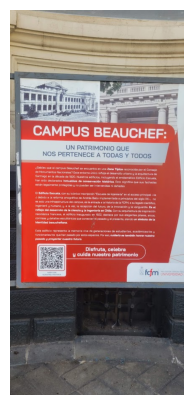

In [ ]:
import matplotlib.pyplot as plt

def show_sample(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    print(type(image))
    plt.axis('off')
    plt.show()

show_sample(OCR_imgs[11])


In [ ]:
from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig

model_id = "llava-hf/llava-1.5-7b-hf"

quant = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)

processor = AutoProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto",
    quantization_config=quant
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/674 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [ ]:
from PIL import Image
import torch

img = Image.open("/content/drive/MyDrive/Imágenes Proyecto/OCR/20250908_140611.jpg").convert("RGB")
prompt = "<image>\nDescribe in detail what you see."

# ✅ usa text=prompt, no solo prompt
inputs = processor(text=prompt, images=img, return_tensors="pt").to("cuda")

out = model.generate(**inputs, max_new_tokens=200)
result = processor.decode(out[0], skip_special_tokens=True)

print(result)




Describe in detail what you see.

The image features a red sign with white text, which reads "Campus Beauchec". The sign is placed on a wall, possibly in a foreign language. The sign is located near the top left corner of the image.


In [ ]:
import os
from datasets import load_dataset

# Verifica que puedas acceder a tu archivo
json_path = "/content/drive/MyDrive/Imágenes Proyecto/annotations.json"
print(os.path.exists(json_path))  # Esto debería devolver True si el archivo está allí


dataset = load_dataset("json", data_files="/content/drive/MyDrive/Imágenes Proyecto/annotations.json")["train"]

print(dataset[0])

True


Generating train split: 0 examples [00:00, ? examples/s]

{'01.jpg': {'ic': {'basic': 'A Chilean 500 peso coin on a banknote.', 'intermediate': 'A gold-colored 500 peso coin from 2002 sits on top of a Chilean banknote. The coin displays its denomination clearly with decorative laurel branches around the edge.', 'advanced': 'A circular bi-metallic Chilean coin showing 500 PESOS denomination dated 2002 rests on a greenish banknote with visible security features and patterns. The coin features prominent numbers with ornamental laurel wreaths encircling the text, showing signs of circulation wear. The underlying currency displays intricate printing details, with the image captured from directly above under natural lighting conditions.'}, 'ocr': []}, '02.jpg': {'ic': {'basic': 'Railroad tracks extending into the distance.', 'intermediate': 'Abandoned railroad tracks stretch across an arid desert landscape under blue skies with white clouds. Rusted industrial structures are visible on the right side.', 'advanced': 'A straight section of deteriorati

In [ ]:
# from PIL import Image
# from datasets import Dataset
# import json
# from transformers import AutoProcessor
# import torch

# # Cargar el archivo .json desde tu Drive
# json_path = "/content/drive/MyDrive/Imágenes Proyecto/annotations.json"
# with open(json_path) as f:
#     annotations = json.load(f)

# # Cargar el processor y el modelo de LLaVA
# model_id = "llava-hf/llava-1.5-7b-hf"
# processor = AutoProcessor.from_pretrained(model_id)

# # Preprocesar las imágenes y las descripciones de texto (IC y OCR)
# def preprocess(example):
#     image_path = f"/content/drive/MyDrive/Imágenes Proyecto/{example}"
#     image = Image.open(image_path).convert("RGB")

#     # Si OCR no está vacío, usar OCR para la extracción de texto
#     if annotations[example]["ocr"]:
#         text = " ".join(annotations[example]["ocr"])  # Combina todas las entradas OCR
#         prompt = f"<image>\nExtract all readable text from the image: {text}"
#     else:
#         # Usar IC para las descripciones cuando OCR está vacío
#         ic_descriptions = annotations[example]["ic"]
#         prompt_basic = f"<image>\n{ic_descriptions.get('basic', '')}"
#         prompt_intermediate = f"<image>\n{ic_descriptions.get('intermediate', '')}"
#         prompt_advanced = f"<image>\n{ic_descriptions.get('advanced', '')}"

#         # Convertir imágenes y los tres niveles de texto a tensores
#         inputs_basic = processor(text=prompt_basic, images=image, return_tensors="pt")
#         inputs_intermediate = processor(text=prompt_intermediate, images=image, return_tensors="pt")
#         inputs_advanced = processor(text=prompt_advanced, images=image, return_tensors="pt")

#         return {
#             "inputs_basic": inputs_basic,
#             "inputs_intermediate": inputs_intermediate,
#             "inputs_advanced": inputs_advanced
#         }

#     # Si OCR está presente, preprocesamos solo el OCR
#     inputs_ocr = processor(text=prompt, images=image, return_tensors="pt")
#     return inputs_ocr

# # Aplicar la función de preprocesamiento a todas las imágenes
# processed_data = {}
# for image_name in annotations.keys():
#     processed_data[image_name] = preprocess(image_name)

# # Crear un dataset para LLaVA
# dataset = Dataset.from_dict(processed_data)

# # Verificar
# print(dataset[0])


# from PIL import Image
# from datasets import Dataset
# import json
# from transformers import AutoProcessor
# import torch

# # Cargar el archivo .json desde tu Drive
# json_path = "/content/drive/MyDrive/Imágenes Proyecto/annotations.json"
# with open(json_path) as f:
#     annotations = json.load(f)

# # Cargar el processor y el modelo de LLaVA
# model_id = "llava-hf/llava-1.5-7b-hf"
# processor = AutoProcessor.from_pretrained(model_id)

# # Preprocesar las imágenes y las descripciones de texto (IC y OCR)
# def preprocess(example):
#     # Asegúrate de que la ruta de la imagen sea completa
#     try:
#         image_path = f"/content/drive/MyDrive/Imágenes Proyecto/IC/{example}"
#         image = Image.open(image_path).convert("RGB")
#     except FileNotFoundError:
#         image_path = f"/content/drive/MyDrive/Imágenes Proyecto/OCR/{example}"
#         image = Image.open(image_path).convert("RGB")

#     # Si OCR no está vacío, usar OCR para la extracción de texto
#     if annotations[example]["ocr"]:
#         text = " ".join(annotations[example]["ocr"])  # Combina todas las entradas OCR
#         prompt = f"<image>\nExtract all readable text from the image: {text}"
#     else:
#         # Usar IC para las descripciones cuando OCR está vacío
#         ic_descriptions = annotations[example]["ic"]
#         prompt_basic = f"<image>\n{ic_descriptions.get('basic', '')}"
#         prompt_intermediate = f"<image>\n{ic_descriptions.get('intermediate', '')}"
#         prompt_advanced = f"<image>\n{ic_descriptions.get('advanced', '')}"

#         # Convertir imágenes y los tres niveles de texto a tensores
#         inputs_basic = processor(text=prompt_basic, images=image, return_tensors="pt")
#         inputs_intermediate = processor(text=prompt_intermediate, images=image, return_tensors="pt")
#         inputs_advanced = processor(text=prompt_advanced, images=image, return_tensors="pt")

#         return {
#             "inputs_basic": inputs_basic,
#             "inputs_intermediate": inputs_intermediate,
#             "inputs_advanced": inputs_advanced
#         }

#     # Si OCR está presente, preprocesamos solo el OCR
#     inputs_ocr = processor(text=prompt, images=image, return_tensors="pt")
#     return inputs_ocr

# # Aplicar la función de preprocesamiento a todas las imágenes
# processed_data = {}
# for image_name in annotations.keys():
#     result = preprocess(image_name)
#     if result:  # Solo agregar si la imagen fue procesada correctamente
#         processed_data[image_name] = result

# # Crear un dataset para LLaVA
# dataset = Dataset.from_dict(processed_data)

# # Verificar
# print(dataset[0])

# from PIL import Image
# from datasets import Dataset
# import json
# from transformers import AutoProcessor
# import torch

# # Cargar el archivo .json desde tu Drive
# json_path = "/content/drive/MyDrive/Imágenes Proyecto/annotations.json"
# with open(json_path) as f:
#     annotations = json.load(f)

# # Cargar el processor y el modelo de LLaVA
# model_id = "llava-hf/llava-1.5-7b-hf"
# processor = AutoProcessor.from_pretrained(model_id)

# # Preprocesar las imágenes y las descripciones de texto (IC y OCR)
# def preprocess(example):
#     # Construir la ruta completa para la imagen

#     try:
#         image_path = f"/content/drive/MyDrive/Imágenes Proyecto/IC/{example}"
#         image = Image.open(image_path).convert("RGB")
#     except FileNotFoundError:
#         image_path = f"/content/drive/MyDrive/Imágenes Proyecto/OCR/{example}"
#         image = Image.open(image_path).convert("RGB")

#     # Si OCR no está vacío, usar OCR para la extracción de texto
#     print(annotations[example]["ocr"])
#     if annotations[example]["ocr"] != []:
#         text = " ".join(annotations[example]["ocr"])  # Combina todas las entradas OCR
#         prompt = f"<image>\nExtract all readable text from the image: {text}"
#         inputs_ocr = processor(text=prompt, images=image, return_tensors="pt")
#         inputs_ocr["labels"] = inputs_ocr["input_ids"]  # Añadir las etiquetas OCR
#         return inputs_ocr
#     else:
#         print("entre con", example)
#         # Usar IC para las descripciones cuando OCR está vacío
#         ic_descriptions = annotations[example]["ic"]
#         prompt_basic = f"<image>\n{ic_descriptions.get('basic', '')}"
#         prompt_intermediate = f"<image>\n{ic_descriptions.get('intermediate', '')}"
#         prompt_advanced = f"<image>\n{ic_descriptions.get('advanced', '')}"

#         # Convertir imágenes y los tres niveles de texto a tensores
#         inputs_basic = processor(text=prompt_basic, images=image, return_tensors="pt")
#         inputs_intermediate = processor(text=prompt_intermediate, images=image, return_tensors="pt")
#         inputs_advanced = processor(text=prompt_advanced, images=image, return_tensors="pt")

#         # Crear un diccionario con los tres niveles de descripción
#         return {
#             "inputs_basic": inputs_basic,
#             "inputs_intermediate": inputs_intermediate,
#             "inputs_advanced": inputs_advanced
#         }

# # Aplicar la función de preprocesamiento a todas las imágenes
# processed_data = {}
# print(annotations.keys())
# print(len(annotations))

# for image_name in annotations.keys():
#     result = preprocess(image_name)
#     if result:  # Solo agregar si la imagen fue procesada correctamente
#         processed_data[image_name] = result

# # Crear un dataset para LLaVA con las columnas adecuadas
# dataset = Dataset.from_dict(processed_data)

# # Verificar
# print(dataset[0])  # Verifica que las columnas sean correctas



# from PIL import Image
# from datasets import Dataset
# import json
# from transformers import AutoProcessor
# import torch

# # Cargar el archivo .json desde tu Drive
# json_path = "/content/drive/MyDrive/Imágenes Proyecto/annotations.json"
# with open(json_path) as f:
#     annotations = json.load(f)

# # Cargar el processor y el modelo de LLaVA
# model_id = "llava-hf/llava-1.5-7b-hf"
# processor = AutoProcessor.from_pretrained(model_id)

# # Preprocesar las imágenes y las descripciones de texto (IC y OCR)
# def preprocess_IC(example):
#     # Construir la ruta completa para la imagen
#     image_path = f"/content/drive/MyDrive/Imágenes Proyecto/IC/{example}"

#     try:
#         # Abrir la imagen
#         image = Image.open(image_path).convert("RGB")
#     except FileNotFoundError:
#         print(f"Imagen no encontrada: {image_path}")
#         return None  # Si no encuentra la imagen, la omite

#     # Usar IC para las descripciones cuando OCR está vacío
#     ic_descriptions = annotations[example]["ic"]

#     # Generar diferentes niveles de descripción para IC
#     prompt_basic = f"<image>\n{ic_descriptions.get('basic', '')}"
#     prompt_intermediate = f"<image>\n{ic_descriptions.get('intermediate', '')}"
#     prompt_advanced = f"<image>\n{ic_descriptions.get('advanced', '')}"

#     # Convertir imágenes y los tres niveles de texto a tensores
#     inputs_basic = processor(text=prompt_basic, images=image, return_tensors="pt")
#     inputs_intermediate = processor(text=prompt_intermediate, images=image, return_tensors="pt")
#     inputs_advanced = processor(text=prompt_advanced, images=image, return_tensors="pt")
#     return {
#         "inputs_basic": inputs_basic,
#         "inputs_intermediate": inputs_intermediate,
#         "inputs_advanced": inputs_advanced
#     }

# def preprocess_OCR(example):
#     # Construir la ruta completa para la imagen
#     image_path = f"/content/drive/MyDrive/Imágenes Proyecto/OCR/{example}"

#     try:
#         # Abrir la imagen
#         image = Image.open(image_path).convert("RGB")
#     except FileNotFoundError:
#         print(f"Imagen no encontrada: {image_path}")
#         return None  # Si no encuentra la imagen, la omite

#     # Si OCR no está vacío, usar OCR para la extracción de texto
#     ocr_text = " ".join(annotations[example]["ocr"])  # Combina todas las entradas OCR
#     prompt = f"<image>\nExtract all readable text from the image: {ocr_text}"

#     # Convertir imágenes y el texto de OCR a tensores
#     inputs_ocr = processor(text=prompt, images=image, return_tensors="pt")
#     inputs_ocr["labels"] = inputs_ocr["input_ids"]  # Añadir las etiquetas OCR

#     return inputs_ocr

# # Crear datasets separados para IC y OCR
# processed_data_ic = {}
# processed_data_ocr = {}

# # Preprocesar IC
# for image_name in annotations.keys():
#     if annotations[image_name]["ocr"] != []:  # Solo procesamos OCR para aquellas imágenes que tienen texto
#         continue  # Saltamos las imágenes que tienen OCR y solo procesamos IC
#     result = preprocess_IC(image_name)
#     if result:
#         processed_data_ic[image_name] = result

# # Preprocesar OCR
# for image_name in annotations.keys():
#     if annotations[image_name]["ocr"] == []:  # Solo procesamos OCR cuando hay texto en la entrada
#         continue  # Saltamos las imágenes que tienen IC y solo procesamos OCR
#     result = preprocess_OCR(image_name)
#     if result:
#         processed_data_ocr[image_name] = result

# # Crear datasets para LLaVA con las columnas adecuadas
# dataset_ic = Dataset.from_dict(processed_data_ic)
# dataset_ocr = Dataset.from_dict(processed_data_ocr)

# # Verificar las estructuras de ambos datasets
# print("Dataset IC:")
# print(dataset_ic[0])

# print("\nDataset OCR:")
# print(dataset_ocr[0])

# from PIL import Image
# from datasets import Dataset
# import json
# from transformers import AutoProcessor
# import torch

# # Cargar el archivo .json desde tu Drive
# json_path = "/content/drive/MyDrive/Imágenes Proyecto/annotations.json"
# with open(json_path) as f:
#     annotations = json.load(f)

# # Cargar el processor y el modelo de LLaVA
# model_id = "llava-hf/llava-1.5-7b-hf"
# processor = AutoProcessor.from_pretrained(model_id)

# # Preprocesar las imágenes y las descripciones de texto (IC y OCR)
# def preprocess(example):
#     # Construir la ruta completa para la imagen
#     image_path = f"/content/drive/MyDrive/Imágenes Proyecto/{example}"

#     try:
#         image_path = f"/content/drive/MyDrive/Imágenes Proyecto/IC/{example}"
#         image = Image.open(image_path).convert("RGB")
#     except FileNotFoundError:
#         image_path = f"/content/drive/MyDrive/Imágenes Proyecto/OCR/{example}"
#         image = Image.open(image_path).convert("RGB")

#     # Si OCR no está vacío, usar OCR para la extracción de texto
#     if annotations[example]["ocr"] != []:
#         ocr_text = " ".join(annotations[example]["ocr"])  # Combina todas las entradas OCR
#         prompt = f"<image>\nExtract all readable text from the image: {ocr_text}"
#         inputs_ocr = processor(text=prompt, images=image, return_tensors="pt")
#         inputs_ocr["labels"] = inputs_ocr["input_ids"]  # Añadir las etiquetas OCR
#         inputs_ocr["pixel_values"] = inputs_ocr["pixel_values"]  # Asegurarse de incluir las imágenes
#         return inputs_ocr
#     else:
#         # Usar IC para las descripciones cuando OCR está vacío
#         ic_descriptions = annotations[example]["ic"]

#         # Generar diferentes niveles de descripción para IC
#         prompt_basic = f"<image>\n{ic_descriptions.get('basic', '')}"
#         prompt_intermediate = f"<image>\n{ic_descriptions.get('intermediate', '')}"
#         prompt_advanced = f"<image>\n{ic_descriptions.get('advanced', '')}"

#         # Convertir imágenes y los tres niveles de texto a tensores
#         inputs_basic = processor(text=prompt_basic, images=image, return_tensors="pt")
#         inputs_intermediate = processor(text=prompt_intermediate, images=image, return_tensors="pt")
#         inputs_advanced = processor(text=prompt_advanced, images=image, return_tensors="pt")

#         # Asegurarse de agregar 'labels' en el formato adecuado
#         inputs_basic["labels"] = inputs_basic["input_ids"]
#         inputs_intermediate["labels"] = inputs_intermediate["input_ids"]
#         inputs_advanced["labels"] = inputs_advanced["input_ids"]

#         return {
#             "inputs_basic": inputs_basic,
#             "inputs_intermediate": inputs_intermediate,
#             "inputs_advanced": inputs_advanced
#         }

# # Aplicar la función de preprocesamiento a todas las imágenes
# processed_data = {}
# for image_name in annotations.keys():
#     result = preprocess(image_name)
#     if result:  # Solo agregar si la imagen fue procesada correctamente
#         processed_data[image_name] = result

# # Crear un dataset para LLaVA con las columnas adecuadas
# dataset = Dataset.from_dict(processed_data)

# # Verificar que las columnas sean correctas
# print(dataset[0])  # Verifica las primeras entradas del dataset


from PIL import Image
from datasets import Dataset
import json
from transformers import AutoProcessor
import torch

# Cargar el archivo .json desde tu Drive
json_path = "/content/drive/MyDrive/Imágenes Proyecto/annotations.json"
with open(json_path) as f:
    annotations = json.load(f)

# Cargar el processor y el modelo de LLaVA
model_id = "llava-hf/llava-1.5-7b-hf"
processor = AutoProcessor.from_pretrained(model_id)

# Preprocesar las imágenes y las descripciones de texto (IC y OCR)
def preprocess(example):
    # Construir la ruta completa para la imagen
    image_path = f"/content/drive/MyDrive/Imágenes Proyecto/{example}"

    try:
        image_path = f"/content/drive/MyDrive/Imágenes Proyecto/IC/{example}"
        image = Image.open(image_path).convert("RGB")
    except FileNotFoundError:
        image_path = f"/content/drive/MyDrive/Imágenes Proyecto/OCR/{example}"
        image = Image.open(image_path).convert("RGB")

    # Si OCR no está vacío, usar OCR para la extracción de texto
    if annotations[example]["ocr"]:
        ocr_text = " ".join(annotations[example]["ocr"])  # Combina todas las entradas OCR
        prompt = f"<image>\nExtract all readable text from the image: {ocr_text}"
        inputs_ocr = processor(text=prompt, images=image, return_tensors="pt")
        inputs_ocr["labels"] = inputs_ocr["input_ids"]  # Añadir las etiquetas OCR
        inputs_ocr["pixel_values"] = inputs_ocr["pixel_values"]  # Asegurarse de incluir las imágenes

        return inputs_ocr

    else:
        # Usar IC para las descripciones cuando OCR está vacío
        ic_descriptions = annotations[example]["ic"]

        # Generar diferentes niveles de descripción para IC
        prompt_basic = f"<image>\n{ic_descriptions.get('basic', '')}"
        prompt_intermediate = f"<image>\n{ic_descriptions.get('intermediate', '')}"
        prompt_advanced = f"<image>\n{ic_descriptions.get('advanced', '')}"

        # Convertir imágenes y los tres niveles de texto a tensores
        inputs_basic = processor(text=prompt_basic, images=image, return_tensors="pt")
        inputs_intermediate = processor(text=prompt_intermediate, images=image, return_tensors="pt")
        inputs_advanced = processor(text=prompt_advanced, images=image, return_tensors="pt")

        # Añadir las etiquetas
        inputs_basic["labels"] = inputs_basic["input_ids"]
        inputs_intermediate["labels"] = inputs_intermediate["input_ids"]
        inputs_advanced["labels"] = inputs_advanced["input_ids"]

        return {
            "inputs_basic": inputs_basic,
            "inputs_intermediate": inputs_intermediate,
            "inputs_advanced": inputs_advanced,

        }

# Aplicar la función de preprocesamiento a todas las imágenes
processed_data = []
for image_name in annotations.keys():
    result = preprocess(image_name)
    if result:  # Solo agregar si la imagen fue procesada correctamente
        if annotations[image_name]["ocr"]:
          processed_data.append(result)

        else:
          basic = image_name[0:len(image_name)-4] + "_basic.jpg"
          inter = image_name[0:len(image_name)-4] + "_intermediate.jpg"
          advance = image_name[0:len(image_name)-4] + "_advanced.jpg"
          processed_data.append(result["inputs_basic"])
          processed_data.append(result["inputs_intermediate"])
          processed_data.append(result["inputs_advanced"])

# Crear un dataset para LLaVA con las columnas adecuadas
data_a_pasar = {}
inputs = []
pixel = []
labels = []
for i in range(len(processed_data)):
  inputs.append(processed_data[i]["input_ids"])
  pixel.append(processed_data[i]["pixel_values"])
  labels.append(processed_data[i]["labels"])
data_a_pasar["input_ids"] = inputs
data_a_pasar["pixel_values"] = pixel
data_a_pasar["labels"] = labels

dataset = Dataset.from_dict(data_a_pasar)

# Verificar las estructuras del dataset
print(dataset[0])  # Verifica las primeras entradas del dataset


{'input_ids': [[1, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 3

In [ ]:
from peft import LoraConfig, get_peft_model
from transformers import TrainingArguments, Trainer

# Configuración LoRA
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

# Cargar el modelo con LoRA
model = get_peft_model(model, lora_config)

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./llava_finetuned",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    learning_rate=1e-4,
    num_train_epochs=4,
    fp16=True,
    logging_steps=10,
    save_total_limit=1,
    report_to="none",      # 👈 esto evita wandb / tensorboard
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
)

trainer.train()


/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:72: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:282: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


TrainOutput(global_step=60, training_loss=5.457117144266764, metrics={'train_runtime': 296.8305, 'train_samples_per_second': 0.809, 'train_steps_per_second': 0.202, 'total_flos': 6634551591985152.0, 'train_loss': 5.457117144266764, 'epoch': 4.0})

# IC

In [ ]:
img = Image.open("/content/drive/MyDrive/Imágenes Proyecto/IC/01.jpg").convert("RGB")
prompt_1 = "<image>\nDescribe briefly what you see."
prompt_2 = "<image>\nDescribe what you see."
prompt_3 = "<image>\nDescribe in detail what you see."

# ✅ usa text=prompt, no solo prompt
inputs_1 = processor(text=prompt_1, images=img, return_tensors="pt").to("cuda")
inputs_2 = processor(text=prompt_2, images=img, return_tensors="pt").to("cuda")
inputs_3 = processor(text=prompt_3, images=img, return_tensors="pt").to("cuda")

out_1 = model.generate(**inputs_1, max_new_tokens=200)
result_1 = processor.decode(out_1[0], skip_special_tokens=True)
out_2 = model.generate(**inputs_2, max_new_tokens=200)
result_2 = processor.decode(out_2[0], skip_special_tokens=True)
out_3 = model.generate(**inputs_3, max_new_tokens=200)
result_3 = processor.decode(out_3[0], skip_special_tokens=True)

print(result_1)
print(result_2)
print(result_3)


Describe briefly what you see.

The image features a silver coin with the word "pesos" written on it. The coin is laying on a table, and it appears to be a 500 peso coin. The coin is the main focus of the image, and it is placed in the center of the frame.

Describe what you see.

The image features a silver coin with a gold color on the edges. The coin is placed on a table, and it appears to be a 500 peso coin. The coin is quite large, covering a significant portion of the table. The coin's design and color make it an interesting and unique piece.

Describe in detail what you see.

The image features a silver coin with a gold color on the edges. The coin is placed on a table, and it appears to be a 500 peso coin. The coin is quite large, covering a significant portion of the table. The table itself is green, providing a contrasting background for the coin.


In [ ]:
img = Image.open("/content/drive/MyDrive/Imágenes Proyecto/IC/02.jpg").convert("RGB")
prompt_1 = "<image>\nDescribe briefly what you see."
prompt_2 = "<image>\nDescribe what you see."
prompt_3 = "<image>\nDescribe in detail what you see."

# ✅ usa text=prompt, no solo prompt
inputs_1 = processor(text=prompt_1, images=img, return_tensors="pt").to("cuda")
inputs_2 = processor(text=prompt_2, images=img, return_tensors="pt").to("cuda")
inputs_3 = processor(text=prompt_3, images=img, return_tensors="pt").to("cuda")

out_1 = model.generate(**inputs_1, max_new_tokens=200)
result_1 = processor.decode(out_1[0], skip_special_tokens=True)
out_2 = model.generate(**inputs_2, max_new_tokens=200)
result_2 = processor.decode(out_2[0], skip_special_tokens=True)
out_3 = model.generate(**inputs_3, max_new_tokens=200)
result_3 = processor.decode(out_3[0], skip_special_tokens=True)

print(result_1)
print(result_2)
print(result_3)


Describe briefly what you see.

The image features a train track running through a desert landscape. The track is surrounded by a barren, rocky terrain, with mountains visible in the distance. The sky above the scene is blue, and the overall atmosphere is quite desolate.

Describe what you see.

The image features a train track running through a desert landscape. The track is surrounded by a barren, rocky terrain, with mountains visible in the distance. The sky above the scene is blue, adding to the overall beauty of the landscape. The train track appears to be empty, with no trains visible in the image.

Describe in detail what you see.

The image features a train track running through a desert landscape. The track is surrounded by a barren, rocky terrain, with mountains visible in the distance. The sky above the scene is blue, adding to the overall beauty of the landscape. The train track appears to be empty, with no trains visible in the image. The overall atmosphere of the scene i

In [ ]:
img = Image.open("/content/drive/MyDrive/Imágenes Proyecto/IC/03.jpg").convert("RGB")
prompt_1 = "<image>\nDescribe briefly what you see."
prompt_2 = "<image>\nDescribe what you see."
prompt_3 = "<image>\nDescribe in detail what you see."

# ✅ usa text=prompt, no solo prompt
inputs_1 = processor(text=prompt_1, images=img, return_tensors="pt").to("cuda")
inputs_2 = processor(text=prompt_2, images=img, return_tensors="pt").to("cuda")
inputs_3 = processor(text=prompt_3, images=img, return_tensors="pt").to("cuda")

out_1 = model.generate(**inputs_1, max_new_tokens=200)
result_1 = processor.decode(out_1[0], skip_special_tokens=True)
out_2 = model.generate(**inputs_2, max_new_tokens=200)
result_2 = processor.decode(out_2[0], skip_special_tokens=True)
out_3 = model.generate(**inputs_3, max_new_tokens=200)
result_3 = processor.decode(out_3[0], skip_special_tokens=True)

print(result_1)
print(result_2)
print(result_3)


Describe briefly what you see.

The image features a person wearing a blue ring on their right hand. The person is sitting down, and their hand is resting on a white object, possibly a remote control. The blue ring stands out against the white background, making it the focal point of the image.

Describe what you see.

The image features a person wearing a blue ring on their right hand. The person is sitting down, and their hand is resting on a white object, possibly a remote control. The blue ring stands out against the white background, making it the focal point of the image.

Describe in detail what you see.

The image features a person wearing a blue ring on their right hand. The person is sitting down, and their hand is resting on a white object, possibly a remote control. The blue ring stands out against the white background, making it the focal point of the image.


In [ ]:
img = Image.open("/content/drive/MyDrive/Imágenes Proyecto/IC/04.jpg").convert("RGB")
prompt_1 = "<image>\nDescribe briefly what you see."
prompt_2 = "<image>\nDescribe what you see."
prompt_3 = "<image>\nDescribe in detail what you see."

# ✅ usa text=prompt, no solo prompt
inputs_1 = processor(text=prompt_1, images=img, return_tensors="pt").to("cuda")
inputs_2 = processor(text=prompt_2, images=img, return_tensors="pt").to("cuda")
inputs_3 = processor(text=prompt_3, images=img, return_tensors="pt").to("cuda")

out_1 = model.generate(**inputs_1, max_new_tokens=200)
result_1 = processor.decode(out_1[0], skip_special_tokens=True)
out_2 = model.generate(**inputs_2, max_new_tokens=200)
result_2 = processor.decode(out_2[0], skip_special_tokens=True)
out_3 = model.generate(**inputs_3, max_new_tokens=200)
result_3 = processor.decode(out_3[0], skip_special_tokens=True)

print(result_1)
print(result_2)
print(result_3)


Describe briefly what you see.

The image captures a beautiful sunset over the ocean. The sun is setting, casting a warm glow over the scene. There are several people scattered across the beach, enjoying the view and the tranquil atmosphere. The people are standing at various distances from the water, taking in the breathtaking view of the sunset.

Describe what you see.

The image captures a beautiful sunset over the ocean. The sun is setting, casting a warm glow over the scene. There are several people scattered across the beach, enjoying the view and the tranquil atmosphere. Some of them are closer to the water, while others are further back on the sand. The overall scene is serene and picturesque, with the sun setting and the people appreciating the natural beauty.

Describe in detail what you see.

The image captures a beautiful sunset over the ocean. The sun is setting, casting a warm glow over the scene. The sky is filled with a variety of birds, some flying closer to the water

In [ ]:
img = Image.open("/content/drive/MyDrive/Imágenes Proyecto/IC/05.jpg").convert("RGB")
prompt_1 = "<image>\nDescribe briefly what you see."
prompt_2 = "<image>\nDescribe what you see."
prompt_3 = "<image>\nDescribe in detail what you see."

# ✅ usa text=prompt, no solo prompt
inputs_1 = processor(text=prompt_1, images=img, return_tensors="pt").to("cuda")
inputs_2 = processor(text=prompt_2, images=img, return_tensors="pt").to("cuda")
inputs_3 = processor(text=prompt_3, images=img, return_tensors="pt").to("cuda")

out_1 = model.generate(**inputs_1, max_new_tokens=200)
result_1 = processor.decode(out_1[0], skip_special_tokens=True)
out_2 = model.generate(**inputs_2, max_new_tokens=200)
result_2 = processor.decode(out_2[0], skip_special_tokens=True)
out_3 = model.generate(**inputs_3, max_new_tokens=200)
result_3 = processor.decode(out_3[0], skip_special_tokens=True)

print(result_1)
print(result_2)
print(result_3)


Describe briefly what you see.

The image features a large field of yellow flowers, with a few clouds in the sky. The flowers are scattered throughout the field, creating a vibrant and lively atmosphere. The field appears to be a popular spot for photography, as the sunlight illuminates the flowers, making them stand out against the backdrop of the sky.

Describe what you see.

The image features a large field filled with yellow flowers. The flowers are scattered throughout the field, creating a vibrant and lively atmosphere. The field is vast, and the flowers are spread out, giving the impression of a vast, open space. The yellow flowers are the main focus of the image, and they create a sense of warmth and beauty.

Describe in detail what you see.

The image features a large field filled with yellow flowers. The flowers are scattered throughout the field, creating a vibrant and lively atmosphere. The field is situated under a cloudy sky, which adds a sense of depth and dimension to 

In [ ]:
img = Image.open("/content/drive/MyDrive/Imágenes Proyecto/IC/06.jpg").convert("RGB")
prompt_1 = "<image>\nDescribe briefly what you see."
prompt_2 = "<image>\nDescribe what you see."
prompt_3 = "<image>\nDescribe in detail what you see."

# ✅ usa text=prompt, no solo prompt
inputs_1 = processor(text=prompt_1, images=img, return_tensors="pt").to("cuda")
inputs_2 = processor(text=prompt_2, images=img, return_tensors="pt").to("cuda")
inputs_3 = processor(text=prompt_3, images=img, return_tensors="pt").to("cuda")

out_1 = model.generate(**inputs_1, max_new_tokens=200)
result_1 = processor.decode(out_1[0], skip_special_tokens=True)
out_2 = model.generate(**inputs_2, max_new_tokens=200)
result_2 = processor.decode(out_2[0], skip_special_tokens=True)
out_3 = model.generate(**inputs_3, max_new_tokens=200)
result_3 = processor.decode(out_3[0], skip_special_tokens=True)

print(result_1)
print(result_2)
print(result_3)


Describe briefly what you see.

The image features a man walking down a sidewalk, carrying a large piano on his back. The man appears to be the main focus of the scene, with the piano being a significant and unusual element. The sidewalk is lined with trees, creating a pleasant and natural atmosphere.

Describe what you see.

The image features a man walking down a sidewalk, carrying a large piano on his back. The man appears to be the main focus of the scene, with the piano being a significant and noticeable part of the image.

In the background, there are several other people, some of whom are walking or standing near the man with the piano. The presence of multiple people in the scene suggests that this might be a busy area or a popular location for people to gather.

Describe in detail what you see.

The image features a man walking down a sidewalk, carrying a large piano on his back. The man appears to be the main focus of the scene, as he navigates the sidewalk with the piano on

In [ ]:
img = Image.open("/content/drive/MyDrive/Imágenes Proyecto/IC/07.jpg").convert("RGB")
prompt_1 = "<image>\nDescribe briefly what you see."
prompt_2 = "<image>\nDescribe what you see."
prompt_3 = "<image>\nDescribe in detail what you see."

# ✅ usa text=prompt, no solo prompt
inputs_1 = processor(text=prompt_1, images=img, return_tensors="pt").to("cuda")
inputs_2 = processor(text=prompt_2, images=img, return_tensors="pt").to("cuda")
inputs_3 = processor(text=prompt_3, images=img, return_tensors="pt").to("cuda")

out_1 = model.generate(**inputs_1, max_new_tokens=200)
result_1 = processor.decode(out_1[0], skip_special_tokens=True)
out_2 = model.generate(**inputs_2, max_new_tokens=200)
result_2 = processor.decode(out_2[0], skip_special_tokens=True)
out_3 = model.generate(**inputs_3, max_new_tokens=200)
result_3 = processor.decode(out_3[0], skip_special_tokens=True)

print(result_1)
print(result_2)
print(result_3)


Describe briefly what you see.

The image features two buses parked next to each other. One bus is upside down, while the other bus is parked in a regular position. The upside-down bus is located on the left side of the image, while the regular bus is on the right side. The scene appears to be set in a parking lot or a similar outdoor area.

Describe what you see.

The image features two buses parked next to each other. One bus is upside down, while the other bus is parked in a regular position. The upside-down bus is located on the left side of the image, while the regular bus is on the right side.

There are several people in the scene, with some standing near the buses and others scattered throughout the area. A car can also be seen in the background, parked further away from the buses.

Describe in detail what you see.

The image features two buses parked next to each other. One bus is upside down, while the other bus is parked in a regular position. The upside-down bus is located

In [ ]:
img = Image.open("/content/drive/MyDrive/Imágenes Proyecto/IC/08.jpg").convert("RGB")
prompt_1 = "<image>\nDescribe briefly what you see."
prompt_2 = "<image>\nDescribe what you see."
prompt_3 = "<image>\nDescribe in detail what you see."

# ✅ usa text=prompt, no solo prompt
inputs_1 = processor(text=prompt_1, images=img, return_tensors="pt").to("cuda")
inputs_2 = processor(text=prompt_2, images=img, return_tensors="pt").to("cuda")
inputs_3 = processor(text=prompt_3, images=img, return_tensors="pt").to("cuda")

out_1 = model.generate(**inputs_1, max_new_tokens=200)
result_1 = processor.decode(out_1[0], skip_special_tokens=True)
out_2 = model.generate(**inputs_2, max_new_tokens=200)
result_2 = processor.decode(out_2[0], skip_special_tokens=True)
out_3 = model.generate(**inputs_3, max_new_tokens=200)
result_3 = processor.decode(out_3[0], skip_special_tokens=True)

print(result_1)
print(result_2)
print(result_3)


Describe briefly what you see.
The image shows a staircase with a white railing. The stairs are located in a building, possibly a theater, as there is a yellow curtain in the background. The stairs are positioned in the middle of the scene, and the railing is prominently visible. The overall atmosphere of the image is dark, giving it a somewhat mysterious feel.

Describe what you see.
The image features a staircase with a white railing. The stairs are located in a room with a doorway, and the staircase appears to be in a darkened area. The staircase is positioned in the middle of the room, and the doorway is located on the right side of the room. The room appears to be empty, with no people or objects visible in the scene.

Describe in detail what you see.
The image features a staircase with a white railing. The stairs are located in a room with a doorway, and the staircase appears to be in a darkened area. The staircase is positioned in the middle of the room, and the doorway is loca

In [ ]:
img = Image.open("/content/drive/MyDrive/Imágenes Proyecto/IC/09.jpg").convert("RGB")
prompt_1 = "<image>\nDescribe briefly what you see."
prompt_2 = "<image>\nDescribe what you see."
prompt_3 = "<image>\nDescribe in detail what you see."

# ✅ usa text=prompt, no solo prompt
inputs_1 = processor(text=prompt_1, images=img, return_tensors="pt").to("cuda")
inputs_2 = processor(text=prompt_2, images=img, return_tensors="pt").to("cuda")
inputs_3 = processor(text=prompt_3, images=img, return_tensors="pt").to("cuda")

out_1 = model.generate(**inputs_1, max_new_tokens=200)
result_1 = processor.decode(out_1[0], skip_special_tokens=True)
out_2 = model.generate(**inputs_2, max_new_tokens=200)
result_2 = processor.decode(out_2[0], skip_special_tokens=True)
out_3 = model.generate(**inputs_3, max_new_tokens=200)
result_3 = processor.decode(out_3[0], skip_special_tokens=True)

print(result_1)
print(result_2)
print(result_3)


Describe briefly what you see.

The image features a large building with a staircase leading to the entrance. Two people are walking up the stairs, possibly entering the building. The building has a distinctive architectural style, and the staircase is well-lit, making it an inviting space. The scene captures the essence of daily life and the importance of accessibility in urban environments.

Describe what you see.

There are two men standing in front of a large building. The building has a large archway and a sign on the side. The men are wearing jackets and appear to be engaged in a conversation. The scene also includes a clock on the wall and a chair nearby. The overall atmosphere suggests a public or commercial building.

Describe in detail what you see.

The image features a large, old building with a staircase leading up to the entrance. Two people are walking up the stairs, possibly entering the building. The building appears to be a school, as there is a sign on the wall indi

In [ ]:
img = Image.open("/content/drive/MyDrive/Imágenes Proyecto/IC/10.jpg").convert("RGB")
prompt_1 = "<image>\nDescribe briefly what you see."
prompt_2 = "<image>\nDescribe what you see."
prompt_3 = "<image>\nDescribe in detail what you see."

# ✅ usa text=prompt, no solo prompt
inputs_1 = processor(text=prompt_1, images=img, return_tensors="pt").to("cuda")
inputs_2 = processor(text=prompt_2, images=img, return_tensors="pt").to("cuda")
inputs_3 = processor(text=prompt_3, images=img, return_tensors="pt").to("cuda")

out_1 = model.generate(**inputs_1, max_new_tokens=200)
result_1 = processor.decode(out_1[0], skip_special_tokens=True)
out_2 = model.generate(**inputs_2, max_new_tokens=200)
result_2 = processor.decode(out_2[0], skip_special_tokens=True)
out_3 = model.generate(**inputs_3, max_new_tokens=200)
result_3 = processor.decode(out_3[0], skip_special_tokens=True)

print(result_1)
print(result_2)
print(result_3)


Describe briefly what you see.

The image features a statue of a man and a dog, with the man sitting on the dog. The statue is located in a park, and the man appears to be wearing a red shirt. The scene is set in a park with a bench nearby. There are several people in the background, possibly enjoying the park or taking a walk.

Describe what you see.

The image features a statue of a man and a dog, with the man sitting on the dog. The statue is located in a park, and it appears to be a popular spot for people to take pictures. There are several people in the vicinity, with some standing closer to the statue and others further away.

In the background, there is a car parked, possibly belonging to one of the visitors to the park. The overall atmosphere of the scene is lively and engaging, with people enjoying the outdoors and the unique statue.

Describe in detail what you see.

The image features a statue of a man and a dog, with the man sitting on the dog. The statue is located in a 

In [ ]:
img = Image.open("/content/drive/MyDrive/Imágenes Proyecto/IC/11.jpg").convert("RGB")
prompt_1 = "<image>\nDescribe briefly what you see."
prompt_2 = "<image>\nDescribe what you see."
prompt_3 = "<image>\nDescribe in detail what you see."

# ✅ usa text=prompt, no solo prompt
inputs_1 = processor(text=prompt_1, images=img, return_tensors="pt").to("cuda")
inputs_2 = processor(text=prompt_2, images=img, return_tensors="pt").to("cuda")
inputs_3 = processor(text=prompt_3, images=img, return_tensors="pt").to("cuda")

out_1 = model.generate(**inputs_1, max_new_tokens=200)
result_1 = processor.decode(out_1[0], skip_special_tokens=True)
out_2 = model.generate(**inputs_2, max_new_tokens=200)
result_2 = processor.decode(out_2[0], skip_special_tokens=True)
out_3 = model.generate(**inputs_3, max_new_tokens=200)
result_3 = processor.decode(out_3[0], skip_special_tokens=True)

print(result_1)
print(result_2)
print(result_3)


Describe briefly what you see.

The image features a group of people working on the outside of a tall building. They are using a crane to reach the higher levels of the building. The scene is set in a city, with cars and a truck visible in the background. The people are focused on their task, and the overall atmosphere suggests a busy urban environment.

Describe what you see.

The image features a group of people working on the outside of a tall building. There are at least six people visible in the scene, with some of them standing on the side of the building. They appear to be working on the building's facade, possibly performing maintenance or construction tasks.

In the background, there are several cars parked along the street, with some of them closer to the foreground and others further away. The cars are parked in various positions, indicating a busy urban area.

Describe in detail what you see.

The image features a group of people working on the outside of a tall building. 

In [ ]:
img = Image.open("/content/drive/MyDrive/Imágenes Proyecto/IC/12.jpg").convert("RGB")
prompt_1 = "<image>\nDescribe briefly what you see."
prompt_2 = "<image>\nDescribe what you see."
prompt_3 = "<image>\nDescribe in detail what you see."

# ✅ usa text=prompt, no solo prompt
inputs_1 = processor(text=prompt_1, images=img, return_tensors="pt").to("cuda")
inputs_2 = processor(text=prompt_2, images=img, return_tensors="pt").to("cuda")
inputs_3 = processor(text=prompt_3, images=img, return_tensors="pt").to("cuda")

out_1 = model.generate(**inputs_1, max_new_tokens=200)
result_1 = processor.decode(out_1[0], skip_special_tokens=True)
out_2 = model.generate(**inputs_2, max_new_tokens=200)
result_2 = processor.decode(out_2[0], skip_special_tokens=True)
out_3 = model.generate(**inputs_3, max_new_tokens=200)
result_3 = processor.decode(out_3[0], skip_special_tokens=True)

print(result_1)
print(result_2)
print(result_3)


Describe briefly what you see.

The image features a large yellow building with a Spanish architectural style. The building has a large arched doorway, and there are several people standing outside of it. Some of the people are carrying backpacks, and a few are holding cell phones. The scene appears to be a busy street with people walking around and engaging in various activities.

Describe what you see.

The image features a large yellow building with a Spanish-style design. The building has a prominent archway, and there is a large sign on the side of the building. The scene is bustling with activity, as several people are walking around the area. Some of the people are carrying backpacks, and a few are wearing ties. The overall atmosphere of the scene is lively and vibrant.

Describe in detail what you see.

The image features a large yellow building with a Spanish-style design. The building has a prominent archway, and there is a large sign on the side of the building. The scene i

In [ ]:
img = Image.open("/content/drive/MyDrive/Imágenes Proyecto/IC/13.jpg").convert("RGB")
prompt_1 = "<image>\nDescribe briefly what you see."
prompt_2 = "<image>\nDescribe what you see."
prompt_3 = "<image>\nDescribe in detail what you see."

# ✅ usa text=prompt, no solo prompt
inputs_1 = processor(text=prompt_1, images=img, return_tensors="pt").to("cuda")
inputs_2 = processor(text=prompt_2, images=img, return_tensors="pt").to("cuda")
inputs_3 = processor(text=prompt_3, images=img, return_tensors="pt").to("cuda")

out_1 = model.generate(**inputs_1, max_new_tokens=200)
result_1 = processor.decode(out_1[0], skip_special_tokens=True)
out_2 = model.generate(**inputs_2, max_new_tokens=200)
result_2 = processor.decode(out_2[0], skip_special_tokens=True)
out_3 = model.generate(**inputs_3, max_new_tokens=200)
result_3 = processor.decode(out_3[0], skip_special_tokens=True)

print(result_1)
print(result_2)
print(result_3)


Describe briefly what you see.

The image features a bustling marketplace with a variety of fruits and vegetables on display. There are several oranges and apples spread across the market, with some oranges placed in the foreground and others in the background. A few apples can be seen in the middle of the scene, while a few more are located towards the right side of the image.

In addition to the fruits, there are a few people present in the market, likely browsing and shopping for fresh produce. The market appears to be a lively and colorful place, with a wide assortment of fruits and vegetables available for purchase.

Describe what you see.

The image features a bustling marketplace with a large display of fresh fruits. There are several crates of oranges, apples, and bananas, all neatly arranged for customers to easily pick out their desired items. The oranges are prominently displayed in the foreground, while the apples and bananas are spread throughout the market.

In addition 

In [ ]:
img = Image.open("/content/drive/MyDrive/Imágenes Proyecto/IC/14.jpg").convert("RGB")
prompt_1 = "<image>\nDescribe briefly what you see."
prompt_2 = "<image>\nDescribe what you see."
prompt_3 = "<image>\nDescribe in detail what you see."

# ✅ usa text=prompt, no solo prompt
inputs_1 = processor(text=prompt_1, images=img, return_tensors="pt").to("cuda")
inputs_2 = processor(text=prompt_2, images=img, return_tensors="pt").to("cuda")
inputs_3 = processor(text=prompt_3, images=img, return_tensors="pt").to("cuda")

out_1 = model.generate(**inputs_1, max_new_tokens=200)
result_1 = processor.decode(out_1[0], skip_special_tokens=True)
out_2 = model.generate(**inputs_2, max_new_tokens=200)
result_2 = processor.decode(out_2[0], skip_special_tokens=True)
out_3 = model.generate(**inputs_3, max_new_tokens=200)
result_3 = processor.decode(out_3[0], skip_special_tokens=True)

print(result_1)
print(result_2)
print(result_3)


Describe briefly what you see.

The image features a large carousel with a group of people riding on it. The carousel is illuminated by lights, creating a vibrant atmosphere. There are at least 13 people visible in the scene, with some of them standing closer to the carousel and others further away. The people are enjoying their time on the carousel, likely at a fair or amusement park.

Describe what you see.

The image features a large, colorful carousel with a group of people standing around it. The carousel is illuminated by lights, creating a vibrant atmosphere. There are at least 13 people visible in the scene, some closer to the carousel and others further away.

A few individuals are carrying handbags, with one person holding a handbag on the left side of the image and another person holding a handbag on the right side. The scene captures the excitement and joy of people gathered around the carousel, likely waiting for their turn to ride.

Describe in detail what you see.

The 

In [ ]:
img = Image.open("/content/drive/MyDrive/Imágenes Proyecto/IC/15.jpg").convert("RGB")
prompt_1 = "<image>\nDescribe briefly what you see."
prompt_2 = "<image>\nDescribe what you see."
prompt_3 = "<image>\nDescribe in detail what you see."

# ✅ usa text=prompt, no solo prompt
inputs_1 = processor(text=prompt_1, images=img, return_tensors="pt").to("cuda")
inputs_2 = processor(text=prompt_2, images=img, return_tensors="pt").to("cuda")
inputs_3 = processor(text=prompt_3, images=img, return_tensors="pt").to("cuda")

out_1 = model.generate(**inputs_1, max_new_tokens=200)
result_1 = processor.decode(out_1[0], skip_special_tokens=True)
out_2 = model.generate(**inputs_2, max_new_tokens=200)
result_2 = processor.decode(out_2[0], skip_special_tokens=True)
out_3 = model.generate(**inputs_3, max_new_tokens=200)
result_3 = processor.decode(out_3[0], skip_special_tokens=True)

print(result_1)
print(result_2)
print(result_3)


Describe briefly what you see.

A man is riding a motorcycle with a man dressed as Santa Claus on the back. The man on the motorcycle is wearing a black jacket and a black helmet. The Santa Claus is wearing a red jacket and a white beard. The scene is set at night, with the motorcycle and Santa Claus being the main focus.

Describe what you see.

In the image, a man is riding a motorcycle with a Santa Claus costume on. The Santa Claus is sitting behind the man, and they are both wearing helmets. The scene appears to be set in a dark environment, possibly at night. The man is holding the handlebars of the motorcycle, and the Santa Claus is sitting on the back of the motorcycle. The image captures a unique and festive moment.

Describe in detail what you see.

The image features a man wearing a Santa Claus suit, riding a motorcycle with another man sitting behind him. The Santa Claus is driving the motorcycle, and the other man is sitting on the back, enjoying the ride. The scene appear

# OCR

In [ ]:
img = Image.open("/content/drive/MyDrive/Imágenes Proyecto/OCR/20250908_140611.jpg").convert("RGB")
prompt = "<image>\nExtract the text of the image."

# ✅ usa text=prompt, no solo prompt
inputs = processor(text=prompt, images=img, return_tensors="pt").to("cuda")

out = model.generate(**inputs, max_new_tokens=200)
result = processor.decode(out[0], skip_special_tokens=True)

print(result)


Extract the text of the image.

The text of the image is:

El libro es un libro de texto que se utiliza para aprender y mejorar el conocimiento. Es un libro que se utiliza para estudiar y mejorar el conocimiento. Es un libro que se utiliza para estudiar y mejorar el conocimiento. Es un libro que se utiliza para estudiar y mejorar el conocimiento. Es un libro que se utiliza para estudiar y mejorar el conocimiento. Es un libro que se utiliza para estudiar y mejorar el conocimiento. Es un libro que se utiliza para estudiar y mejorar el conocimiento. Es un libro que se utiliza para estudiar y mejorar el conocimiento. Es un libro que se utiliza para estudiar y mejorar el conocimiento. Es un libro que se utiliza para estudiar y mejorar el conocimiento. Es un libro que se utiliza para estudiar y mejorar el


In [ ]:
img = Image.open("/content/drive/MyDrive/Imágenes Proyecto/OCR/20250908_154959.jpg").convert("RGB")
prompt = "<image>\nExtract the text of the image."

# ✅ usa text=prompt, no solo prompt
inputs = processor(text=prompt, images=img, return_tensors="pt").to("cuda")

out = model.generate(**inputs, max_new_tokens=200)
result = processor.decode(out[0], skip_special_tokens=True)

print(result)


Extract the text of the image.

The text of the image is:

"Efedico, constructido para albergar el Idem, fue inaugurado el 20 de diciembre de 1952, en una ceremonia que contó con la presencia del Presidente de la República, Carlos Ibáñez, el Rector de la Universidad de Chile, Julio Hernández, y el Director del IDEM, Edmundo Thompsen."


In [ ]:
img = Image.open("/content/drive/MyDrive/Imágenes Proyecto/OCR/20250908_155938.jpg").convert("RGB")
prompt = "<image>\nExtract the text of the image."

# ✅ usa text=prompt, no solo prompt
inputs = processor(text=prompt, images=img, return_tensors="pt").to("cuda")

out = model.generate(**inputs, max_new_tokens=200)
result = processor.decode(out[0], skip_special_tokens=True)

print(result)


Extract the text of the image.

The text of the image is:

Este es el lugar donde se encuentra la memoria histórica de la televisión chilena. Este lugar es el punto de partida para la transmisión de la televisión en Chile. Este lugar es el punto de llegada para la transmisión de la televisión en Chile. Este lugar es el punto de partida para la transmisión de la televisión en Chile. Este lugar es el punto de llegada para la transmisión de la televisión en Chile. Este lugar es el punto de partida para la transmisión de la televisión en Chile. Este lugar es el punto de llegada para la transmisión de la televisión en Chile. Este lugar es el punto de partida para la transmisión de la televisión en Chile. Este lugar es el punto de llegada para la transmisión de la televisión en Chile. Este lugar es el punto de partida para la transmisión de la televis


In [ ]:
img = Image.open("/content/drive/MyDrive/Imágenes Proyecto/OCR/20250908_160638.jpg").convert("RGB")
prompt = "<image>\nExtract the text of the image."

# ✅ usa text=prompt, no solo prompt
inputs = processor(text=prompt, images=img, return_tensors="pt").to("cuda")

out = model.generate(**inputs, max_new_tokens=200)
result = processor.decode(out[0], skip_special_tokens=True)

print(result)


Extract the text of the image.

The text of the image is:

"Memorialia Historia"

"Medallones a la derrota e izquierda de la parte superior derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha derecha


In [ ]:
img = Image.open("/content/drive/MyDrive/Imágenes Proyecto/OCR/20250819_074858.jpg").convert("RGB")
prompt = "<image>\nExtract the text of the image."

# ✅ usa text=prompt, no solo prompt
inputs = processor(text=prompt, images=img, return_tensors="pt").to("cuda")

out = model.generate(**inputs, max_new_tokens=200)
result = processor.decode(out[0], skip_special_tokens=True)

print(result)


Extract the text of the image.

The text of the image is:

"Curtel
La empresa de bomberos de San Telmo
Salvadores i guardia de propiedad
Rindido homenaje a quien fuere director fundador
Don Manuel Antonio Mata
Sexagésimo aniversario de fundación
Ago 2023"


In [ ]:
img = Image.open("/content/drive/MyDrive/Imágenes Proyecto/OCR/20250819_074905.jpg").convert("RGB")
prompt = "<image>\nExtract the text of the image."

# ✅ usa text=prompt, no solo prompt
inputs = processor(text=prompt, images=img, return_tensors="pt").to("cuda")

out = model.generate(**inputs, max_new_tokens=200)
result = processor.decode(out[0], skip_special_tokens=True)

print(result)


Extract the text of the image.

The text of the image is:

En este lugar, el 18 de febrero de 1862, se libró la Batalla del Mar, en la que se enfrentaron las fuerzas de la Patria, al mando del General Juan Williams, y las de la rebelión, al mando del General José María Córdova.

Esta placa conmemora la gloriosa victoria obtenida por nuestros padres, en la que se demostró su valentía, su entrega y su amor por la Patria.

La Batalla del Mar fue una de las más importantes de la Guerra de la Independencia. Se libró en el marco de la Campaña de Occidente, en la que las fuerzas patriotas, al mando del General Juan Williams, lograron expulsar a las fuerzas realistas,


In [ ]:
img = Image.open("/content/drive/MyDrive/Imágenes Proyecto/OCR/20220101_035959.jpg").convert("RGB")
prompt = "<image>\nExtract the text of the image."

# ✅ usa text=prompt, no solo prompt
inputs = processor(text=prompt, images=img, return_tensors="pt").to("cuda")

out = model.generate(**inputs, max_new_tokens=200)
result = processor.decode(out[0], skip_special_tokens=True)

print(result)


Extract the text of the image.

The text of the image is:

Por orden del S.C. Consistorio se prohíbe entrar a la iglesia de San Pedro y San Pablo al desapego de bebidas.

Febrero 1882.


In [ ]:
img = Image.open("/content/drive/MyDrive/Imágenes Proyecto/OCR/20230214_122422.jpg").convert("RGB")
prompt = "<image>\nExtract the text of the image."

# ✅ usa text=prompt, no solo prompt
inputs = processor(text=prompt, images=img, return_tensors="pt").to("cuda")

out = model.generate(**inputs, max_new_tokens=200)
result = processor.decode(out[0], skip_special_tokens=True)

print(result)


Extract the text of the image.

The text of the image is: "El Museo Historico Nacional Esta Abre Entrada Gratuita Te Esperamos"


In [ ]:
img = Image.open("/content/drive/MyDrive/Imágenes Proyecto/OCR/20230430_150424.jpg").convert("RGB")
prompt = "<image>\nExtract the text of the image."

# ✅ usa text=prompt, no solo prompt
inputs = processor(text=prompt, images=img, return_tensors="pt").to("cuda")

out = model.generate(**inputs, max_new_tokens=200)
result = processor.decode(out[0], skip_special_tokens=True)

print(result)


Extract the text of the image.

The text of the image is:

"Smilodon: The enormous saber-toothed cat found further back in the Pleistocene. All carnivores have teeth that are adapted to their diet. Smilodons are known for their large, curved canines, which are used to tear flesh from their prey. Smilodons are also known for their powerful jaw muscles, which allow them to exert great force when biting. Smilodons are the strongest mammals on Earth, with the strongest bite of any land animal. Smilodons are also the fastest land animals, with a top speed of 30 miles per hour. Smilodons are found in the Pleistocene of North America, Europe, and Asia. Smilodons are the most common saber-toothed cats found in the Pleistocene of North


In [ ]:
img = Image.open("/content/drive/MyDrive/Imágenes Proyecto/OCR/20230511_133754.jpg").convert("RGB")
prompt = "<image>\nExtract the text of the image."

# ✅ usa text=prompt, no solo prompt
inputs = processor(text=prompt, images=img, return_tensors="pt").to("cuda")

out = model.generate(**inputs, max_new_tokens=200)
result = processor.decode(out[0], skip_special_tokens=True)

print(result)


Extract the text of the image.

The text of the image is:

"Memoria Historica"

"IFM"

"Construido de Lines de Decada de 1900 y 1940 para Albergar la Escuela de Ciencias Fisicas y Matematicas. En 1944 la Escuela de Ciencias Fisicas y Matematicas fue trasladada a su actual ubicación. En 1944 la Escuela de Ciencias Fisicas y Matematicas fue trasladada a su actual ubicación. En 1944 la Escuela de Ciencias Fisicas y Matematicas fue trasladada a su actual ubicación. En 1944 la Escuela de Ciencias Fisicas y Matematicas fue trasladada a su actual ubicación. En 1944 la Escuela de Ciencias F


In [ ]:
img = Image.open("/content/drive/MyDrive/Imágenes Proyecto/OCR/20230811_151805.jpg").convert("RGB")
prompt = "<image>\nExtract the text of the image."

# ✅ usa text=prompt, no solo prompt
inputs = processor(text=prompt, images=img, return_tensors="pt").to("cuda")

out = model.generate(**inputs, max_new_tokens=200)
result = processor.decode(out[0], skip_special_tokens=True)

print(result)


Extract the text of the image.

The text of the image is:

"En el 1955, un experimento en el que se pudo observar el efecto de la música en el comportamiento de los niños. El experimento consistió en colocar a los niños en una habitación con música de diferentes tonos y intensidades. Los resultados mostraron que los niños que escuchaban música de bajo tono y intensidad se comportaban de manera más tranquila y relajada, mientras que los niños que escuchaban música de alto tono y intensidad se comportaban de manera más excitada y nerviosa. Este experimento demostró que la música puede tener un efecto significativo en el comportamiento de los niños."


In [ ]:
img = Image.open("/content/drive/MyDrive/Imágenes Proyecto/OCR/20231108_090334.jpg").convert("RGB")
prompt = "<image>\nExtract the text of the image."

# ✅ usa text=prompt, no solo prompt
inputs = processor(text=prompt, images=img, return_tensors="pt").to("cuda")

out = model.generate(**inputs, max_new_tokens=200)
result = processor.decode(out[0], skip_special_tokens=True)

print(result)


Extract the text of the image.

The image is a poster with a woman on it. The woman is wearing a dress and appears to be standing on a staircase. The poster is displayed in a room, possibly a museum. The room has a glass door, and there is a chair located in the background. The overall atmosphere of the room suggests that it is a place where people can gather and discuss the displayed posters.


In [ ]:
img = Image.open("/content/drive/MyDrive/Imágenes Proyecto/OCR/20240401_124930.jpg").convert("RGB")
prompt = "<image>\nExtract the text of the image."

# ✅ usa text=prompt, no solo prompt
inputs = processor(text=prompt, images=img, return_tensors="pt").to("cuda")

out = model.generate(**inputs, max_new_tokens=200)
result = processor.decode(out[0], skip_special_tokens=True)

print(result)


Extract the text of the image.

The text of the image is:

"Memoria Historia De La Fisica El Edificio De La Fisica El Edificio De La Fisica El Edificio De La Fisica El Edificio De La Fisica El Edificio De La Fisica El Edificio De La Fisica El Edificio De La Fisica El Edificio De La Fisica El Edificio De La Fisica El Edificio De La Fisica El Edificio De La Fisica El Edificio De La Fisica El Edificio De La Fisica El Edificio De La Fisica El Edificio De La Fisica El Edificio De La Fisica El Edificio De La Fisica El Edificio De La Fisica El Edificio De La Fisica El Edificio De La Fisica


In [ ]:
img = Image.open("/content/drive/MyDrive/Imágenes Proyecto/OCR/20240603_120302.jpg").convert("RGB")
prompt = "<image>\nExtract the text of the image."

# ✅ usa text=prompt, no solo prompt
inputs = processor(text=prompt, images=img, return_tensors="pt").to("cuda")

out = model.generate(**inputs, max_new_tokens=200)
result = processor.decode(out[0], skip_special_tokens=True)

print(result)


Extract the text of the image.

The text of the image is:

"El Voto"

"Deposita el Voto en la Urna"

"La Voz de la Gente"

"La Mayoria y la Responsabilidad"

"Ciudadanos eligidos"

"Sus Gobernantes"

"El Voto"

"Deposita el Voto en la Urna"

"La Voz de la Gente"

"La Mayoria y la Responsabilidad"

"Ciudadanos eligidos"

"Sus Gobernantes"

"El Voto"

"Deposita el Voto en la Urna"

"La Voz de la Gente"

"La Mayoria y la Responsabilidad"

"Ciudadanos eligidos"




In [ ]:
img = Image.open("/content/drive/MyDrive/Imágenes Proyecto/OCR/20250331_130243.jpg").convert("RGB")
prompt = "<image>\nExtract the text of the image."

# ✅ usa text=prompt, no solo prompt
inputs = processor(text=prompt, images=img, return_tensors="pt").to("cuda")

out = model.generate(**inputs, max_new_tokens=200)
result = processor.decode(out[0], skip_special_tokens=True)

print(result)


Extract the text of the image.

The text of the image is:

Facultad de Ciencias Físicas y Matemáticas
Universidad de Chile
Beauchef 860

The text is in Spanish.


# Metricas

In [ ]:
!pip install -q jiwer nltk rouge-score evaluate
!pip install nltk

import nltk
from nltk.translate.meteor_score import meteor_score
nltk.download('wordnet')
nltk.download('punkt')

import os, json, gc
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch

from jiwer import wer, cer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 73.9 MB/s eta 0:00:00


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
OCR_path = '/content/drive/MyDrive/Imágenes Proyecto/OCR'
IC_path  = '/content/drive/MyDrive/Imágenes Proyecto/IC'
annotations_path = '/content/drive/MyDrive/Imágenes Proyecto/annotations.json'
results_path = '/content/drive/MyDrive/Imágenes Proyecto/results_llava.json'
final_results_path = '/content/drive/MyDrive/Imágenes Proyecto/results_llava_final.json'
plots_folder = '/content/drive/MyDrive/Imágenes Proyecto/'

with open(annotations_path, 'r', encoding='utf-8') as f:
    annotations = json.load(f)

print("Anotaciones:", len(annotations))

from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig

model_id = "llava-hf/llava-1.5-7b-hf"

# Si aún no cargaste processor y model en tu notebook, descomenta y ajusta:
# quant = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)
# processor = AutoProcessor.from_pretrained(model_id)
# model = LlavaForConditionalGeneration.from_pretrained(
#     model_id,
#     torch_dtype=torch.float16,
#     device_map="auto",
#     quantization_config=quant
# )


Anotaciones: 30


In [ ]:
ocr_prompts = [
    "<image>\nExtract all the text you can see in this image. Write only the text, nothing else.",
    "<image>\nRead and transcribe all visible text from this image."
]

ic_prompts = {
    "basic": "<image>\nDescribe this image in 1-2 simple sentences.",
    "intermediate": "<image>\nDescribe this image in 3-5 sentences, including context and details.",
    "advanced": "<image>\nProvide a detailed description of this image in 6-8 sentences. Include objects, people, actions, colors, atmosphere, and context."
}

def generate_llava_response(image_path, prompt, max_new_tokens=256):
    try:
        img = Image.open(image_path).convert("RGB")
        inputs = processor(text=prompt, images=img, return_tensors="pt").to("cuda")
        out = model.generate(**inputs, max_new_tokens=max_new_tokens)
        resp = processor.decode(out[0], skip_special_tokens=True)
        return resp.strip()
    except Exception as e:
        print("ERROR generate:", e)
        return ""

def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


In [ ]:
def calculate_cer(reference, hypothesis):
    if not hypothesis:
        return 1.0
    if isinstance(reference, list):
        refs = [r for r in reference if r]
        if not refs:
            return 1.0
        scores = [cer(r, hypothesis) for r in refs]
        return float(min(scores))
    return float(cer(reference, hypothesis))

def calculate_wer(reference, hypothesis):
    if not hypothesis:
        return 1.0
    if isinstance(reference, list):
        refs = [r for r in reference if r]
        if not refs:
            return 1.0
        scores = [wer(r, hypothesis) for r in refs]
        return float(min(scores))
    return float(wer(reference, hypothesis))

def calculate_bleu(reference, hypothesis):
    if not hypothesis:
        return 0.0
    if reference is None:
        return 0.0
    if isinstance(reference, dict):
        refs = [v for v in reference.values() if v]
    elif isinstance(reference, list):
        refs = [r for r in reference if r]
    else:
        refs = [reference]
    if not refs:
        return 0.0
    references_tokenized = [r.split() for r in refs]
    hyp_tokens = hypothesis.split()
    smooth = SmoothingFunction().method1
    try:
        return float(sentence_bleu(references_tokenized, hyp_tokens, smoothing_function=smooth))
    except:
        return 0.0

def calculate_meteor(reference, hypothesis):
    """
    Calcula METEOR score.
    reference puede ser lista, dict o string.
    hypothesis es el output del modelo.
    """
    if not hypothesis:
        return 0.0

    # Si reference viene como dict (caso IC)
    if isinstance(reference, dict):
        refs = [v for v in reference.values() if v]
    # Si es una lista (varias anotaciones)
    elif isinstance(reference, list):
        refs = [r for r in reference if r]
    else:
        refs = [reference]

    if not refs:
        return 0.0

    # meteor_score acepta listas de referencias
    try:
        return float(meteor_score(refs, hypothesis))
    except:
        return 0.0



In [ ]:
all_results=[]

OCR_path = "/content/drive/MyDrive/Imágenes Proyecto/OCR"

ocr_images = [
    f for f in sorted(os.listdir(OCR_path))
    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))
]

for img_name in tqdm(ocr_images, desc="OCR"):
    img_path = os.path.join(OCR_path, img_name)

    # Asegura que haya anotación OCR
    if img_name not in annotations or "ocr" not in annotations[img_name]:
        continue

    gt_texts = annotations[img_name]["ocr"]

    # Normalizar formato
    if isinstance(gt_texts, str):
        gt_list = [gt_texts]
    else:
        gt_list = gt_texts

    entry = {
        "image_path": f"OCR/{img_name}",
        "model": model_id,
        "task": "OCR",
        "annotations": gt_list,
        "prompt_outputs": []
    }

    for prompt in ocr_prompts:
        out = generate_llava_response(img_path, prompt, max_new_tokens=512)
        cer_score = calculate_cer(gt_list, out)
        wer_score = calculate_wer(gt_list, out)

        entry["prompt_outputs"].append({
            "prompt": prompt,
            "output": out,
            "scores": {
                "score_a": round(cer_score, 4),
                "score_b": round(wer_score, 4)
            }
        })

        clear_memory()

    all_results.append(entry)

    if len(all_results) % 5 == 0:
        with open(results_path, "w", encoding="utf-8") as f:
            json.dump(all_results, f, indent=2, ensure_ascii=False)


OCR: 100%|██████████| 15/15 [03:51<00:00, 15.45s/it]


In [ ]:
IC_path = "/content/drive/MyDrive/Imágenes Proyecto/IC"

ic_images = [
    f for f in sorted(os.listdir(IC_path))
    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))
]

for img_name in tqdm(ic_images, desc="IC"):
    img_path = os.path.join(IC_path, img_name)

    # Asegura que haya anotación IC
    if img_name not in annotations or "ic" not in annotations[img_name]:
        continue

    ic_ann = annotations[img_name]["ic"]  # dict: basic/intermediate/advanced

    entry = {
        "image_path": f"IC/{img_name}",
        "model": model_id,
        "task": "IC",
        "annotations": ic_ann,
        "prompt_outputs": []
    }

    # ---- 1. Generar caption + BLEU
    for level, prompt in ic_prompts.items():
        out = generate_llava_response(img_path, prompt, max_new_tokens=512)
        bleu_score = calculate_bleu(ic_ann, out)

        entry["prompt_outputs"].append({
            "prompt": prompt,
            "level": level,
            "output": out,
            "scores": {
                "score_a": round(bleu_score, 4),
                "score_b": None
            }
        })

        clear_memory()

    # ---- 2. METEOR
    for po in entry["prompt_outputs"]:
        meteor = calculate_meteor(ic_ann, po["output"])
        po["scores"]["score_b"] = round(meteor, 4)

    all_results.append(entry)

    if len(all_results) % 5 == 0:
        with open(results_path, "w", encoding="utf-8") as f:
            json.dump(all_results, f, indent=2, ensure_ascii=False)


IC: 100%|██████████| 15/15 [04:27<00:00, 17.86s/it]


In [ ]:
final_results_path = "/content/drive/MyDrive/Imágenes Proyecto/results_llava_final_nuevo.json"
plots_folder        = "/content/drive/MyDrive/Imágenes Proyecto/"

In [ ]:
with open(final_results_path, 'w', encoding='utf-8') as f:
    json.dump(all_results, f, indent=2, ensure_ascii=False)

# Estadísticas (igual al script completo)
# ... (usa el bloque del script completo para histogramas y CSV)


✓ Resultados cargados: 30 entradas


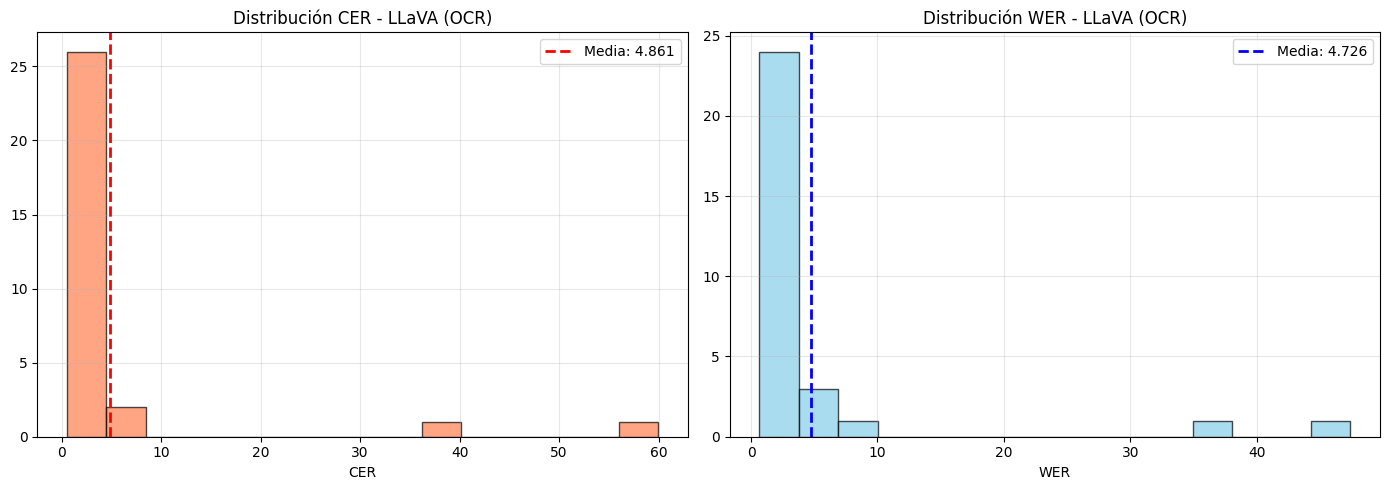

✓ Gráfico OCR guardado en: /content/drive/MyDrive/Imágenes Proyecto/llava_ocr_metrics.png


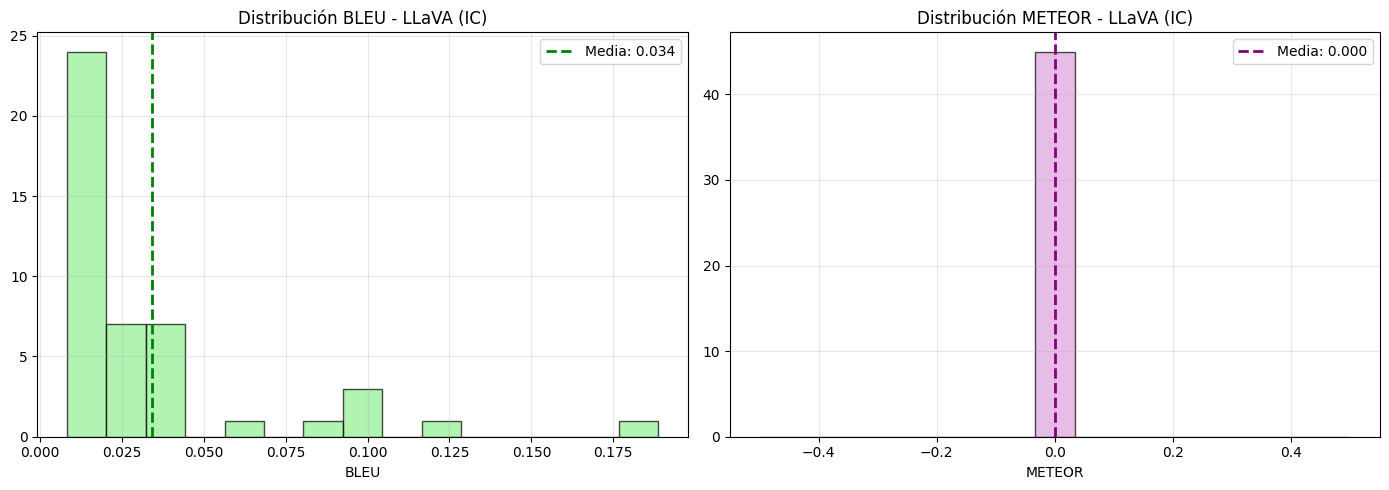

✓ Gráfico IC guardado en: /content/drive/MyDrive/Imágenes Proyecto/llava_ic_metrics.png
✓ Resumen guardado en: /content/drive/MyDrive/Imágenes Proyecto/llava_summary.csv

📊 Todo listo: gráficos, métricas y tabla resumen generados para LLaVA.


In [ ]:
# ============================================
# GRAFICAR Y ANALIZAR RESULTADOS LLaVA 1.5-7B
# ============================================

import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# --- Paths (ajusta si tu carpeta NO tiene tilde) ---
final_results_path = "/content/drive/MyDrive/Imágenes Proyecto/results_llava_final_nuevo.json"
plots_folder = "/content/drive/MyDrive/Imágenes Proyecto/"

# --- Cargar resultados ---
with open(final_results_path, "r", encoding="utf-8") as f:
    results = json.load(f)

print(f"✓ Resultados cargados: {len(results)} entradas")
ocr_results = [r for r in results if r["task"] == "OCR"]
ic_results  = [r for r in results if r["task"] == "IC"]

# OCR
ocr_cer = [po["scores"]["score_a"] for r in ocr_results for po in r["prompt_outputs"]]
ocr_wer = [po["scores"]["score_b"] for r in ocr_results for po in r["prompt_outputs"]]

# IC
ic_bleu   = [po["scores"]["score_a"] for r in ic_results for po in r["prompt_outputs"]]
ic_meteor = [po["scores"]["score_b"] for r in ic_results for po in r["prompt_outputs"]]


# ============================================
# EXTRAER MÉTRICAS OCR
# ============================================
ocr_cer = []
ocr_wer = []

for r in ocr_results:
    for po in r["prompt_outputs"]:
        ocr_cer.append(po["scores"]["score_a"])
        ocr_wer.append(po["scores"]["score_b"])

# ============================================
# EXTRAER MÉTRICAS IC
# ============================================
ic_bleu = []
ic_bert = []

for r in ic_results:
    for po in r["prompt_outputs"]:
        ic_bleu.append(po["scores"]["score_a"])
        ic_bert.append(po["scores"]["score_b"])

# ============================================
# GRAFICAR HISTOGRAMAS OCR
# ============================================
if len(ocr_cer) > 0:
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    ax[0].hist(ocr_cer, bins=15, color="coral", edgecolor="black", alpha=0.7)
    ax[0].axvline(np.mean(ocr_cer), color="red", linestyle="--", linewidth=2, label=f"Media: {np.mean(ocr_cer):.3f}")
    ax[0].set_title("Distribución CER - LLaVA (OCR)")
    ax[0].set_xlabel("CER")
    ax[0].legend()
    ax[0].grid(alpha=0.3)

    ax[1].hist(ocr_wer, bins=15, color="skyblue", edgecolor="black", alpha=0.7)
    ax[1].axvline(np.mean(ocr_wer), color="blue", linestyle="--", linewidth=2, label=f"Media: {np.mean(ocr_wer):.3f}")
    ax[1].set_title("Distribución WER - LLaVA (OCR)")
    ax[1].set_xlabel("WER")
    ax[1].legend()
    ax[1].grid(alpha=0.3)

    plt.tight_layout()
    out_path = os.path.join(plots_folder, "llava_ocr_metrics.png")
    plt.savefig(out_path, dpi=300)
    plt.show()
    print("✓ Gráfico OCR guardado en:", out_path)

# ============================================
# GRAFICAR HISTOGRAMAS IC
# ============================================
if len(ic_bleu) > 0:
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # BLEU
    ax[0].hist(ic_bleu, bins=15, color="lightgreen", edgecolor="black", alpha=0.7)
    ax[0].axvline(np.mean(ic_bleu), color="green", linestyle="--", linewidth=2, label=f"Media: {np.mean(ic_bleu):.3f}")
    ax[0].set_title("Distribución BLEU - LLaVA (IC)")
    ax[0].set_xlabel("BLEU")
    ax[0].legend()
    ax[0].grid(alpha=0.3)

    # METEOR
    ax[1].hist(ic_meteor, bins=15, color="plum", edgecolor="black", alpha=0.7)
    ax[1].axvline(np.mean(ic_meteor), color="purple", linestyle="--", linewidth=2, label=f"Media: {np.mean(ic_meteor):.3f}")
    ax[1].set_title("Distribución METEOR - LLaVA (IC)")
    ax[1].set_xlabel("METEOR")
    ax[1].legend()
    ax[1].grid(alpha=0.3)

    plt.tight_layout()
    out_path = os.path.join(plots_folder, "llava_ic_metrics.png")
    plt.savefig(out_path, dpi=300)
    plt.show()
    print("✓ Gráfico IC guardado en:", out_path)


# ============================================
# TABLA RESUMEN PARA EL INFORME (igual que Qwen)
# ============================================
summary = {
    "Tarea":   ["OCR", "OCR", "IC", "IC"],
    "Métrica": ["CER", "WER", "BLEU", "METEOR"],
    "Media": [
        float(np.mean(ocr_cer)) if ocr_cer else 0,
        float(np.mean(ocr_wer)) if ocr_wer else 0,
        float(np.mean(ic_bleu)) if ic_bleu else 0,
        float(np.mean(ic_meteor)) if ic_meteor else 0,
    ],
    "Std": [
        float(np.std(ocr_cer)) if ocr_cer else 0,
        float(np.std(ocr_wer)) if ocr_wer else 0,
        float(np.std(ic_bleu)) if ic_bleu else 0,
        float(np.std(ic_meteor)) if ic_meteor else 0,
    ],
    "Min": [
        float(np.min(ocr_cer)) if ocr_cer else 0,
        float(np.min(ocr_wer)) if ocr_wer else 0,
        float(np.min(ic_bleu)) if ic_bleu else 0,
        float(np.min(ic_meteor)) if ic_meteor else 0,
    ],
    "Max": [
        float(np.max(ocr_cer)) if ocr_cer else 0,
        float(np.max(ocr_wer)) if ocr_wer else 0,
        float(np.max(ic_bleu)) if ic_bleu else 0,
        float(np.max(ic_meteor)) if ic_meteor else 0,
    ]
}

df_summary = pd.DataFrame(summary)
summary_path = os.path.join(plots_folder, "llava_summary.csv")
df_summary.to_csv(summary_path, index=False)

print("✓ Resumen guardado en:", summary_path)


print("\n📊 Todo listo: gráficos, métricas y tabla resumen generados para LLaVA.")


In [ ]:
# ==========================================================
#   RESULTADOS FORMATO INFORME PARA OCR + IC (CON METEOR)
#   idéntico al estilo mostrado en tus screenshots
# ==========================================================

import numpy as np
import json

# Ruta final
final_results_path = "/content/drive/MyDrive/Imágenes Proyecto/results_llava_final_nuevo.json"

with open(final_results_path, "r", encoding="utf-8") as f:
    results = json.load(f)

# Separar OCR e IC
ocr_results = [r for r in results if r["task"] == "OCR"]
ic_results  = [r for r in results if r["task"] == "IC"]

# ========================
#      OCR METRICS
# ========================
ocr_cer = []
ocr_wer = []

for r in ocr_results:
    for po in r["prompt_outputs"]:
        ocr_cer.append(po["scores"]["score_a"])
        ocr_wer.append(po["scores"]["score_b"])

print("="*70)
print("                      PROMEDIOS OCR")
print("="*70)

if len(ocr_cer) > 0:
    print("\n🟧 CER: {:.4f} ± {:.4f}".format(np.mean(ocr_cer), np.std(ocr_cer)))
    print("   Rango: [{:.4f}, {:.4f}]".format(np.min(ocr_cer), np.max(ocr_cer)))

    print("\n🟧 WER: {:.4f} ± {:.4f}".format(np.mean(ocr_wer), np.std(ocr_wer)))
    print("   Rango: [{:.4f}, {:.4f}]".format(np.min(ocr_wer), np.max(ocr_wer)))

    print("\nTotal muestras:", len(ocr_cer))
else:
    print("No hay datos OCR.")


# ========================
#      IC POR NIVEL
# ========================
print("\n\n" + "="*70)
print("                   PROMEDIOS POR NIVEL (IC)")
print("="*70 + "\n")

levels = ["basic", "intermediate", "advanced"]

# Inicializar contenedores
stats = {
    "basic":       {"bleu": [], "meteor": []},
    "intermediate":{"bleu": [], "meteor": []},
    "advanced":    {"bleu": [], "meteor": []},
}

# Rellenar datos
for r in ic_results:
    for po in r["prompt_outputs"]:
        lvl = po["level"].lower()
        if lvl in stats:
            stats[lvl]["bleu"].append(po["scores"]["score_a"])
            stats[lvl]["meteor"].append(po["scores"]["score_b"])


# Imprimir cada nivel
for lvl in levels:
    bleu_vals   = stats[lvl]["bleu"]
    meteor_vals = stats[lvl]["meteor"]

    print("="*70)
    print(f"🔶 {lvl.upper()}")
    print("="*70)

    if len(bleu_vals) > 0:
        print("BLEU: {:.4f} ± {:.4f}".format(np.mean(bleu_vals), np.std(bleu_vals)))
        print("Rango BLEU: [{:.4f}, {:.4f}]".format(np.min(bleu_vals), np.max(bleu_vals)))

        print("\nMETEOR: {:.4f} ± {:.4f}".format(np.mean(meteor_vals), np.std(meteor_vals)))
        print("Rango METEOR: [{:.4f}, {:.4f}]".format(np.min(meteor_vals), np.max(meteor_vals)))

        print("Muestras:", len(bleu_vals))
    else:
        print("No hay datos para este nivel.")

    print("\n")

# ==========================
# PROMEDIO GLOBAL (IC)
# ==========================
all_bleu   = []
all_meteor = []

for lvl in levels:
    all_bleu   += stats[lvl]["bleu"]
    all_meteor += stats[lvl]["meteor"]

print("="*70)
print("          🟩 PROMEDIO GENERAL (TODOS LOS NIVELES)")
print("="*70)

if len(all_bleu) > 0:
    print("BLEU:   {:.4f} ± {:.4f}".format(np.mean(all_bleu), np.std(all_bleu)))
    print("METEOR: {:.4f} ± {:.4f}".format(np.mean(all_meteor), np.std(all_meteor)))
    print("Total:", len(all_bleu))
else:
    print("No hay datos IC.")


                      PROMEDIOS OCR

🟧 CER: 4.8615 ± 12.0598
   Rango: [0.5279, 59.9286]

🟧 WER: 4.7264 ± 10.0758
   Rango: [0.6552, 47.4286]

Total muestras: 30


                   PROMEDIOS POR NIVEL (IC)

🔶 BASIC
BLEU: 0.0503 ± 0.0455
Rango BLEU: [0.0169, 0.1886]

METEOR: 0.0000 ± 0.0000
Rango METEOR: [0.0000, 0.0000]
Muestras: 15


🔶 INTERMEDIATE
BLEU: 0.0227 ± 0.0214
Rango BLEU: [0.0083, 0.0997]

METEOR: 0.0000 ± 0.0000
Rango METEOR: [0.0000, 0.0000]
Muestras: 15


🔶 ADVANCED
BLEU: 0.0294 ± 0.0305
Rango BLEU: [0.0092, 0.1011]

METEOR: 0.0000 ± 0.0000
Rango METEOR: [0.0000, 0.0000]
Muestras: 15


          🟩 PROMEDIO GENERAL (TODOS LOS NIVELES)
BLEU:   0.0341 ± 0.0359
METEOR: 0.0000 ± 0.0000
Total: 45
